The img from the video where the annotation was done is extracted, also the creation of train, val, and test set are created. Also the number of object is converved in the creationof the train dataset.

In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import json
from collections import Counter
import numpy as np
import os
import shutil
import json
import random
from collections import defaultdict
import random

## Utils functions

In [3]:
def check_img_annot(path_img, path_txt):
    frame = cv2.imread(path_img).copy()
    box = []
    with open(path_txt, "r") as f:
        for i in f:
            box.append(i.split())
    #print("box : class, x, y, w, h \n", box)
    f.close()

    for boxx in box:
        
        cl,x,y,w,h = [eval(i) for i in boxx]

        h_frame,w_frame,channel = frame.shape

        # top left
        xtl = int(x*w_frame-w*w_frame/2)
        ytl = int(y*h_frame+h*h_frame/2)

        # bottom right
        xbr = int(x*w_frame+w*w_frame/2)
        ybr = int(y*h_frame-h*h_frame/2)

        frame = cv2.rectangle(frame, (xtl,ytl),(xbr,ybr),(0,255,0),2 )

    plt.imshow(frame)
    plt.show()

In [4]:
def coco_to_yolo(coco_bbox, image_width, image_height):
    x_min, y_min, width, height = coco_bbox
    
    # COCO format to YOLO format
    center_x = (x_min + width / 2) / image_width
    center_y = (y_min + height / 2) / image_height
    yolo_width = width / image_width
    yolo_height = height / image_height
    
    return [center_x, center_y, yolo_width, yolo_height]

def yolo_to_coco(yolo_bbox, image_width, image_height):
    center_x, center_y, yolo_width, yolo_height = yolo_bbox
    
    # YOLO format to COCO format
    x_min = int((center_x - yolo_width / 2) * image_width)
    y_min = int((center_y - yolo_height / 2) * image_height)
    width = int(yolo_width * image_width)
    height = int(yolo_height * image_height)
    
    return [x_min, y_min, width, height]

In [5]:
def get_data(video_path, annotation_path, data_save_path, per=1, per_train=80, per_val=10):
    info = {}

    # IMAGES WITH ANNOTATION
    data = json.load(open(annotation_path))
    set_img = {i["image_id"] for i in data["annotations"]}

    # REDIMENTION OF IMG
    cap = cv2.VideoCapture(video_path)
    _,frame = cap.read()
    Ho,Wo,_=frame.shape
    r = frame.shape[0]/frame.shape[1] # H/W
    new_W = frame.shape[1]/per
    new_H = r*new_W
    dim = (int(new_W), int(new_H))
    
    
    try:
        os.mkdir(os.path.join(data_save_path,"images"))
    except:
        print("directory 'images' was created")
        print("all new file will be add")
        print()
    
    # SAVE IMAGES WITH ANNOTATIONS IN "images"
    count = 1
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    name_video = video_path.split("/")[-1].split(".")[0]
    
    while success:
        name = os.path.join(data_save_path,"images",
                            name_video+"_frame_"+str(count)+".png")
        if count in set_img:
            resized = cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)
            cv2.imwrite(name,resized)  # SAVE IMG
        success, frame = cap.read()
        count = count + 1
    cap.release()
    
    # SAVE ANNOTATION .TXT IN "labels"
    try:
        os.mkdir(os.path.join(data_save_path, "labels"))
    except:
        print("directory 'labels' was created")
        print("all news files will be add")
            
    for i in data["annotations"]:
        f = open(os.path.join(data_save_path,"labels",
                              name_video+"_frame_"+str(i["image_id"])+".txt"),"a")
        f.write(str(int(i["category_id"]-1))+ " ")
    
        # cl,x,y,w,h = [eval(i) for i in boxx] YOLO
        # # Bboxes are in [top-left-x, top-left-y, width, height]  COCO
        box = coco_to_yolo(i["bbox"], new_W, new_H)

        # due of resized
        box[0] = box[0]*new_W/Wo
        box[1] = box[1]*new_H/Ho
        box[2] = box[2]*new_W/Wo
        box[3] = box[3]*new_H/Ho
        
        for b in box:
            f.write( f"{b:.5f}" + " ")
        f.write("\n")
        f.close()
    
    # CREATE VAL, TEST, TRAIN
    '''
    labels = os.listdir(os.path.join(data_save_path,"labels"))
    train_labels = labels[0:int((len(labels) * per_train)/100)]
    val_labels = labels[int((len(labels) * per_train)/100):int((len(labels) * (per_train+per_val))/100)]
    test_labels = labels[int(len(labels) * (per_val+per_train)/100):]
    
    print("Directories to train")
    print("total : ", len(labels))
    print("train : ", len(train_labels))
    print("test  : ", len(test_labels))
    print("val   : ", len(val_labels))

    # copy images to train, val and test folders
    try:
        os.mkdir(os.path.join(data_save_path,"Train"))
    except:
        print("directory 'Train' was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Train","images"))
    except:
        print("directory 'Train/images' was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Train","labels"))
    except:
        print("directory was created")
        print("all new file will be add")

    for label in train_labels:
        filename = label.split(".")[0]
        #path = os.getcwd()
        # images source and destination path
        img_src = data_save_path+"/images/"+filename+'.png'
        img_dst = data_save_path+'/Train/images/'+filename+'.png'
        # labels source and destination path
        label_src = data_save_path+'/labels/'+filename+'.txt'
        label_dst = data_save_path+'/Train/labels/'+filename+'.txt'
        
        shutil.copy(img_src, img_dst)
        shutil.copy(label_src, label_dst)

    try:
        os.mkdir(os.path.join(data_save_path,"Val"))
    except:
        print("directory 'Val' was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Val","images"))
    except:
        print("directory 'Val/images' created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Val","labels"))
    except:
        print("directory was created")
        print("all new file will be add")


    for label in val_labels:
        filename = label.split(".")[0]
        #path = os.getcwd()
        # images source and destination path
        img_src = data_save_path+'/images/'+filename+'.png'
        img_dst = data_save_path+'/Val/images/'+filename+'.png'
        # labels source and destination path
        label_src = data_save_path+'/labels/'+filename+'.txt'
        label_dst = data_save_path+'/Val/labels/'+filename+'.txt'
        
        shutil.copy(img_src, img_dst)
        shutil.copy(label_src, label_dst)

    try:
        os.mkdir(os.path.join(data_save_path,"Test"))
    except:
        print("directory was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Test","images"))
    except:
        print("directory was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Test","labels"))
    except:
        print("directory was created")
        print("all new file will be add")


    for label in test_labels:
        filename = label.split(".")[0]
        #path = os.getcwd()
        # images source and destination path
        img_src = data_save_path+'/images/'+filename+'.png'
        img_dst = data_save_path+'/Test/images/'+filename+'.png'
        # labels source and destination path
        label_src = data_save_path+'/labels/'+filename+'.txt'
        label_dst = data_save_path+'/Test/labels/'+filename+'.txt'
        
        shutil.copy(img_src, img_dst)
        shutil.copy(label_src, label_dst)
'''

    info["categories"] = data["categories"]
    return info


# Get Raster Data

In [8]:
data = json.load(open('../data/video1.json'))

In [9]:
info = get_data(video_path="../data/video1.mp4", 
        annotation_path="../data/video1.json",
        data_save_path="../data/dataset", per=1)

# Train-Test dataset

In [10]:
test_size = 0.2
val_percent = 0.2

In [11]:
txt_dir = '../data/dataset/labels'

## Split stratified

It is created train_set, test_set, val_set with the following format:
- {'video1_frame_18986.png': ['9',  '0',  '0',  ...  '10',  '10',  '9'], ... }

In [12]:
import os
from collections import defaultdict, Counter

# Set directory path
txt_dir = '../data/dataset/labels'

# image_to_classes: Mapping from image file to list of class labels (with possible duplicates)
class_to_images = defaultdict(list)
image_to_classes = {}

# Load all the text files and associate each image with its classes
for txt_file in os.listdir(txt_dir):
    if txt_file.endswith('.txt'):
        image_name = txt_file.replace('.txt', '.png')  # Assuming images are in .png format
        with open(os.path.join(txt_dir, txt_file), 'r') as file:
            classes_in_image = []  # List to store all class labels (including duplicates)
            for line in file:
                class_label = line.split()[0]  # Assuming class label is the first entry in each row
                class_to_images[class_label].append(image_name)
                classes_in_image.append(class_label)  # Add the class to the list (including duplicates)
            image_to_classes[image_name] = classes_in_image  # Store all classes (including duplicates)

# Step 1: Count the occurrences of each class across all images
class_counts = Counter()
for classes in image_to_classes.values():
    class_counts.update(classes)  # Count each class occurrence, including duplicates

# Step 2: Define proportional split for train, test, and validation sets
train_set = {}
test_set = {}
val_set = {}
current_test_counts = Counter()
current_val_counts = Counter()

# Split ratios (adjust these values as needed)
test_size = 0.2  # 20% for test set
val_size = 0.2  # 20% for validation set
train_size = 1 - test_size - val_size  # The remaining for the train set

# Step 3: Split the data while maintaining proportionality
for image, classes in image_to_classes.items():
    # Check if we can add to the test set
    if all(current_test_counts[cls] / class_counts[cls] <= test_size for cls in classes):
        test_set[image] = classes
        current_test_counts.update(classes)  # Update test set counts for each class
    # Check if we can add to the validation set
    elif all(current_val_counts[cls] / class_counts[cls] <= val_size for cls in classes):
        val_set[image] = classes
        current_val_counts.update(classes)  # Update validation set counts for each class
    else:
        # Otherwise, add to the train set
        train_set[image] = classes

# Print the result
print(f"Train set: {len(train_set)} images")
print(f"Test set: {len(test_set)} images")
print(f"Validation set: {len(val_set)} images")

# Optionally, you can also check the class distribution in train, test, and validation sets
train_class_counts = Counter([cls for classes in train_set.values() for cls in classes])
test_class_counts = Counter([cls for classes in test_set.values() for cls in classes])
val_class_counts = Counter([cls for classes in val_set.values() for cls in classes])

print("\nClass distribution in Train set:")
for class_label, count in train_class_counts.items():
    print(f"{class_label}: {count} instances")

print("\nClass distribution in Test set:")
for class_label, count in test_class_counts.items():
    print(f"{class_label}: {count} instances")

print("\nClass distribution in Validation set:")
for class_label, count in val_class_counts.items():
    print(f"{class_label}: {count} instances")

# Final overall class counts (including repeated classes)
print("\nOverall class counts (including duplicates):")
for class_label, count in class_counts.items():
    print(f"{class_label}: {count} instances")

Train set: 952 images
Test set: 286 images
Validation set: 287 images

Class distribution in Train set:
0: 1390 instances
10: 667 instances
2: 1145 instances
13: 15 instances
7: 142 instances
1: 1177 instances
5: 832 instances
8: 459 instances
4: 98 instances
11: 212 instances
3: 47 instances
9: 72 instances
6: 28 instances
18: 13 instances
14: 21 instances
15: 5 instances

Class distribution in Test set:
10: 223 instances
1: 389 instances
5: 279 instances
0: 314 instances
7: 49 instances
8: 154 instances
2: 274 instances
6: 10 instances
11: 8 instances
13: 4 instances
4: 5 instances
3: 9 instances
9: 8 instances
18: 6 instances
14: 4 instances

Class distribution in Validation set:
2: 357 instances
5: 278 instances
8: 154 instances
7: 49 instances
1: 372 instances
0: 428 instances
10: 223 instances
11: 4 instances
6: 10 instances
13: 6 instances
4: 2 instances
9: 11 instances
18: 6 instances
3: 1 instances
14: 1 instances

Overall class counts (including duplicates):
10: 1113 instance

## Plot distribution data set

In [13]:
categories = [{'id': 1, 'name': '1_Auto Privado', 'supercategory': ''},
              {'id': 2, 'name': '13_Bus', 'supercategory': ''},
              {'id': 3, 'name': '11_Camioneta rural', 'supercategory': ''},
              {'id': 4, 'name': '12_Microbus', 'supercategory': ''},
              {'id': 5, 'name': '4_Mototaxi', 'supercategory': ''},
              {'id': 6, 'name': '5_Moto lineal', 'supercategory': ''},
              {'id': 7, 'name': '9_Omnibus Interprovincial', 'supercategory': ''},
              {'id': 8, 'name': '10_Auto colectivo', 'supercategory': ''},
              {'id': 9, 'name': '14_Articulado', 'supercategory': ''},
              {'id': 10, 'name': '2_Cam. PickUp', 'supercategory': ''},
              {'id': 11, 'name': '3_Taxi', 'supercategory': ''},
              {'id': 12, 'name': '6_Bicicletas', 'supercategory': ''},
              {'id': 13, 'name': '7_Scooter', 'supercategory': ''},
              {'id': 14, 'name': '8_TransportenEscolar Personal', 'supercategory': ''},
              {'id': 15, 'name': '15_TC_Ligeros', 'supercategory': ''},
              {'id': 16, 'name': '16_TC Pesados', 'supercategory': ''},
              {'id': 17, 'name': '17_TC SemiTrailler Trailer', 'supercategory': ''},
              {'id': 18, 'name': '18_Triciclo', 'supercategory': ''},
              {'id': 19, 'name': '19_Ambulancia', 'supercategory': ''}]

In [14]:
categories[1]['name']

'13_Bus'

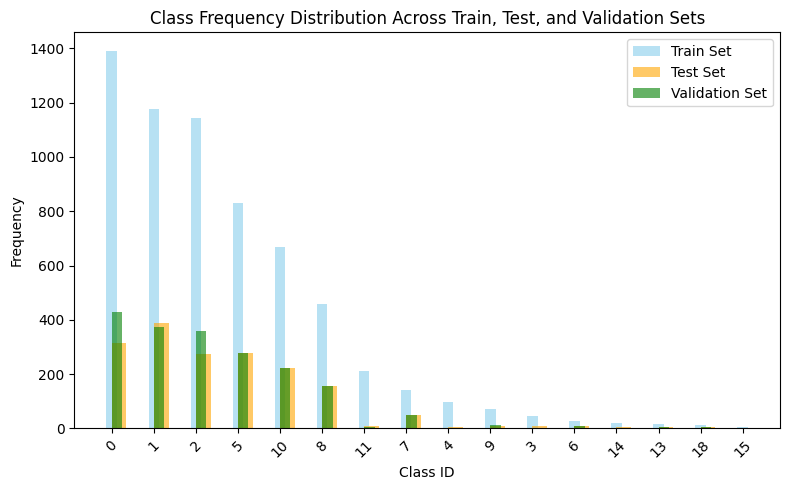

In [15]:
import matplotlib.pyplot as plt
from collections import Counter


# Function to count classes in a dataset and return a sorted list of class counts
def get_class_counts(dataset):
    all_classes = [cls for classes in dataset.values() for cls in classes]  # Flatten the list
    class_counts = Counter(all_classes)  # Count frequency of each class
    return class_counts.most_common()  # Sort by frequency in descending order

# Get sorted class counts for each dataset
train_class_counts = get_class_counts(train_set)
test_class_counts = get_class_counts(test_set)
val_class_counts = get_class_counts(val_set)

# Unzip the sorted counts into class ids and frequencies
train_class_ids, train_counts = zip(*train_class_counts)
test_class_ids, test_counts = zip(*test_class_counts)
val_class_ids, val_counts = zip(*val_class_counts)


# Create a single figure and axis
plt.figure(figsize=(8, 5))

# Plot each dataset with a different color
plt.bar(train_class_ids, train_counts, color='skyblue', label='Train Set', alpha=0.6, width=0.25, align='center')
plt.bar(test_class_ids, test_counts, color='orange', label='Test Set', alpha=0.6, width=0.35, align='edge')
plt.bar(val_class_ids, val_counts, color='green', label='Validation Set', alpha=0.6, width=0.25, align='edge')

# Add labels and title
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.title('Class Frequency Distribution Across Train, Test, and Validation Sets')

# Add a legend to differentiate the sets
plt.legend()

# Optional: Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout for better fit
plt.tight_layout()

# Display the plot
plt.show()

## Create .txt and val

In [16]:
train_set = list(train_set.keys())
test_set = list(test_set.keys())
val_set = list(val_set.keys())

In [17]:
test_set = ['../data/dataset/images/'+i for i in test_set]
train_set = ['../data/dataset/images/'+i for i in train_set]
val_set = ['../data/dataset/images/'+i for i in val_set]

In [18]:
# Open the file in write mode
with open('../data/dataset/test.txt', 'w') as file:
    for item in test_set:
        file.write(f"{item}\n")

with open('../data/dataset/train.txt', 'w') as file :
    for item in train_set:
        file.write(f'{item}\n')
        
with open('../data/dataset/val.txt', 'w') as file :
    for item in val_set:
        file.write(f'{item}\n')

'../data/dataset/images/video1_frame_13411.png'

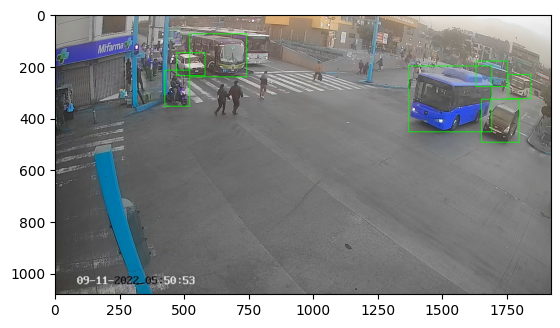

In [25]:
check_img_annot('../data/dataset/images/video1_frame_321.png', 
                '../data/dataset/labels/video1_frame_321.txt')

In [28]:
video = cv2.VideoCapture("../data/video1.mp4")
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

In [31]:
(952/30143)*100

3.158278870716252